In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### get the hourly ED occupancy

In [2]:
hourly = pd.read_pickle('./../../data/interim/D3_dailyTS/EDhourly_occupancy.pkl')

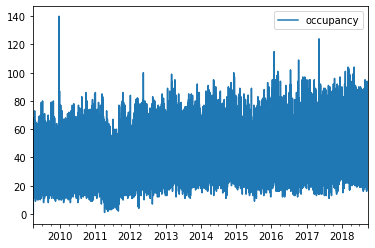

In [3]:
hourly.plot()

#### get timeindex to iterate over

#### save data out

EDinstance.to_pickle('./../../data/interim/D3_dailyTS/EDhourly_occupancy.pkl')

#### group hourly data to daily data

At present using a mean of the occupancy for each day. We could consider using a max or 0.75 quantile?

In [4]:
hourly['dt_date'] = hourly.index

In [5]:
pd.datetime(2018,1,1,11).replace(hour=0)

datetime.datetime(2018, 1, 1, 0, 0)

In [6]:
hourly['dt_date'] = hourly.dt_date.apply(lambda x : x.replace(hour=0))

In [7]:
hourly.tail()

,occupancy,dt_date
2018-09-29 20:00:00,46,2018-09-29
2018-09-29 21:00:00,58,2018-09-29
2018-09-29 22:00:00,54,2018-09-29
2018-09-29 23:00:00,55,2018-09-29
2018-09-30 00:00:00,57,2018-09-30


In [8]:
daily = pd.DataFrame(hourly.groupby(['dt_date']).mean()['occupancy'])

In [9]:
daily.head(2)

,occupancy
dt_date,
2009-04-01,28.458333
2009-04-02,36.875000


# flag outlier function 

In [10]:
def make_callender_columns(df,column,prefix):
    """
    takes a datetime column and creates multiple new columns with: hour of day, day of week, month of year.
    Input
    df, df: dataframe
    column, str: name of datetime column to work from
    prefix, str: give prefix for new column names

    Output
    df, df: new df with additional columns with numerical indicators for callender vars.
    """
    dft = df # needed for cases which do not have missing datetime values

    if df[column].isnull().sum() != 0:
        warnings.warn('Some datetimes in your column are missing.')
        dft = df[df[column].notnull()] # create ref of df without rows that contain missing vals


    df[prefix + '_hour'] = dft[column].dt.hour.astype(int)
    df[prefix + '_dayofweek'] = dft[column].dt.dayofweek.astype(int)
    df[prefix + '_day'] = dft[column].dt.day.astype(int)
    df[prefix + '_month'] = dft[column].dt.month.astype(int)
    df[prefix + '_week'] = dft[column].dt.week.astype(int)
    df[prefix + '_dayofweek_name'] = dft[column].dt.weekday_name.astype(str)
    df[prefix + '_year'] = dft[column].dt.year.astype(int)
    df[prefix + '_date'] = dft[column].dt.date.astype(object)
    df[prefix + '_flag_wkend'] = (df[prefix + '_dayofweek'] > 5).astype(int)
    return(df)

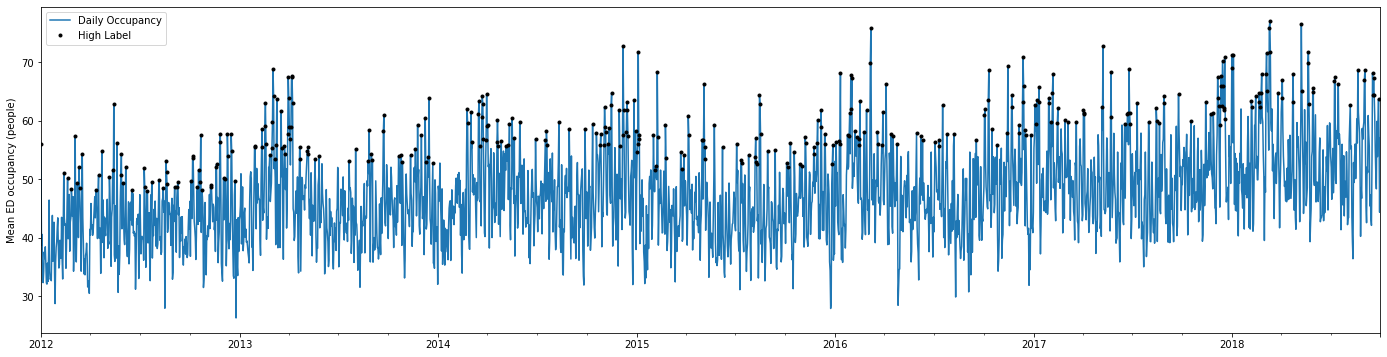

In [11]:
# from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(24,6))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
        ax.legend(['Daily Occupancy','High Label'],frameon=True,loc='upper left')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(daily,'occupancy',0.85,True,[2012,2013,2014,2015,2016,2017,2018])

## New approaches

Two other possible approaches:
1) rolling quantile of 0.85 exceeded
2) looking at previsou year and flagging if in 0.85 percentile.

#### first must tidy up period in 2011 which shows a big drop 

(note this period will not be used in any of the training/prediction but will be used for calcuating the quantile to label the year 2012)

In [12]:
### loo kat period after
s = pd.datetime(2011,9,10)
e = pd.datetime(2011,12,14)
df.loc[s:e].occupancy.describe()

count    96.000000
mean     39.274306
std       5.139777
min      28.791667
25%      36.250000
50%      38.833333
75%      42.031250
max      56.416667
Name: occupancy, dtype: float64

In [13]:
sample_array = df.loc[s:e].occupancy.values # get samples to make new values from just after th epriod

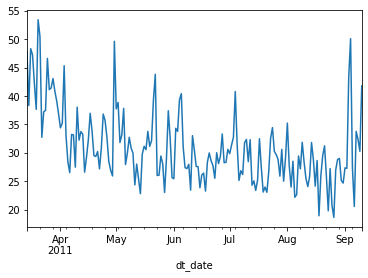

In [14]:
#### period to change
s = pd.datetime(2011,3,14)
e = pd.datetime(2011,9,10)
df.loc[s:e].occupancy.plot()

In [15]:
df.loc[s:e].shape

(181, 2)

In [16]:
np.random.seed(891)
new_sample = (np.random.choice(sample_array, 181))

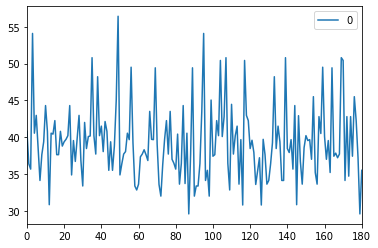

In [17]:
pd.DataFrame(new_sample).plot()

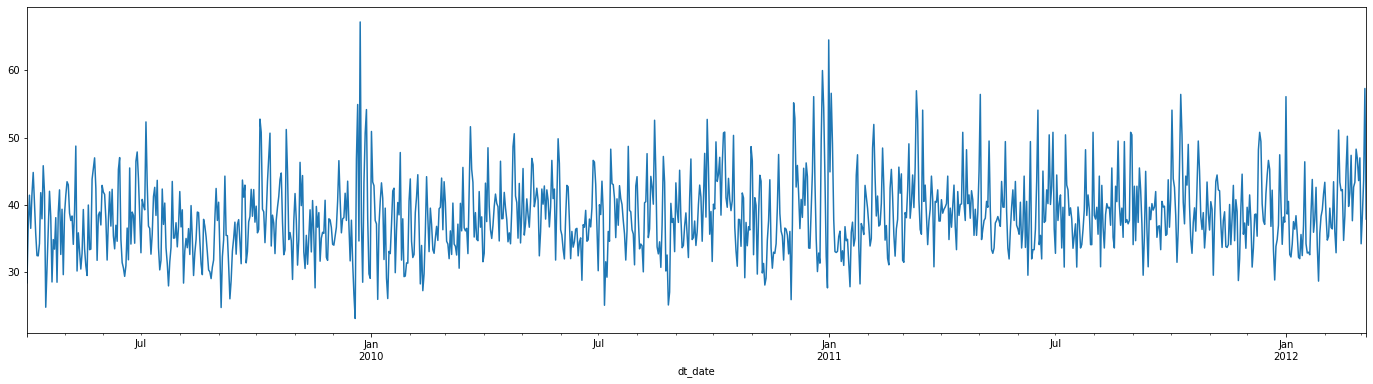

In [18]:
##### apply new sample to timeseries
df.loc[s:e, 'occupancy'] = new_sample

#### plot corrected timeseries
dff = df[-3600:-2400]

target_col = 'occupancy'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))

### rolling quantile aproach

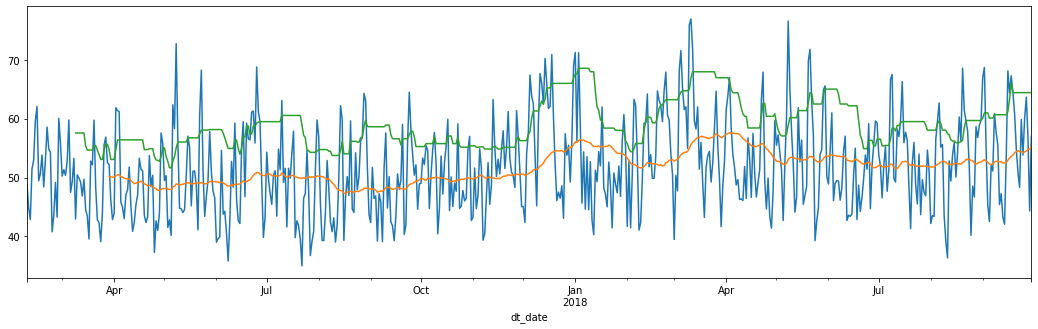

In [19]:
dff = df[-600:]
dff.occupancy.plot(figsize=(18,5))
dff.occupancy.rolling(50).mean().plot()
dff.occupancy.rolling(30).quantile(0.85).plot()

In [20]:
df['class_RollingQuantile30d'] = (df.occupancy > df.occupancy.rolling(30).quantile(0.90)).astype(int)
df['class_RollingQuantile365d'] = (df.occupancy > df.occupancy.rolling(360).quantile(0.9)).astype(int)

df.sum()

occupancy                    155303.541667
flag_target                     519.000000
class_RollingQuantile30d        370.000000
class_RollingQuantile365d       403.000000
dtype: float64

### comparing previsou approache s

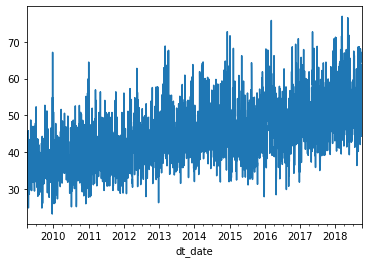

In [21]:
df.occupancy.plot()

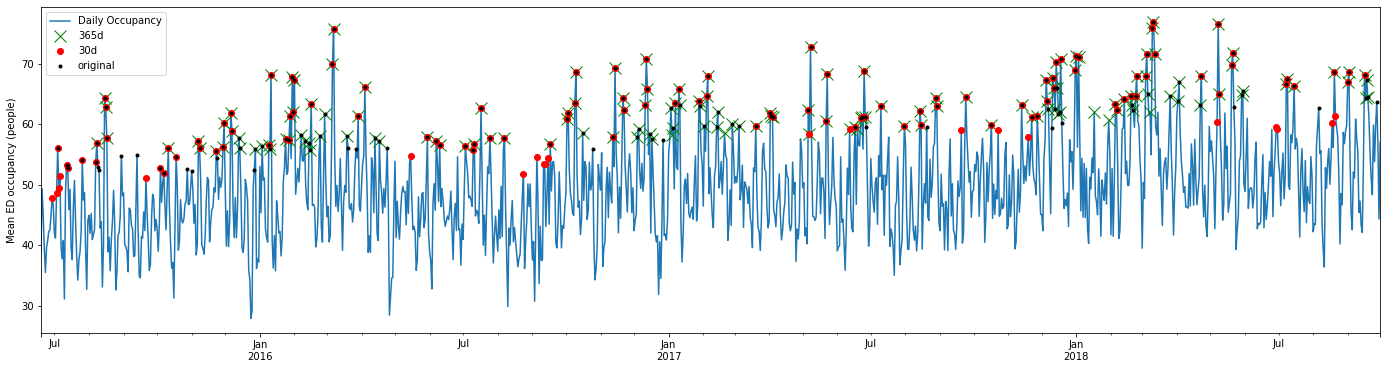

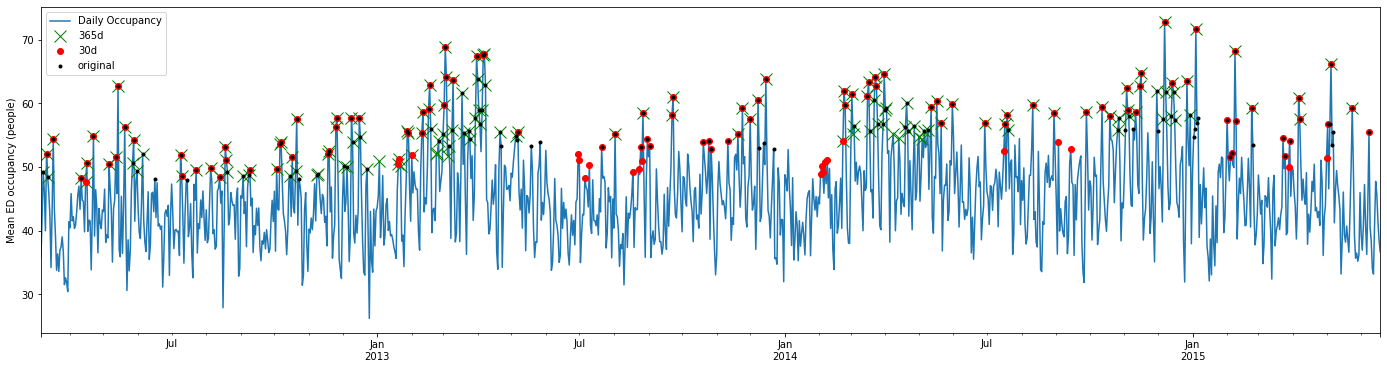

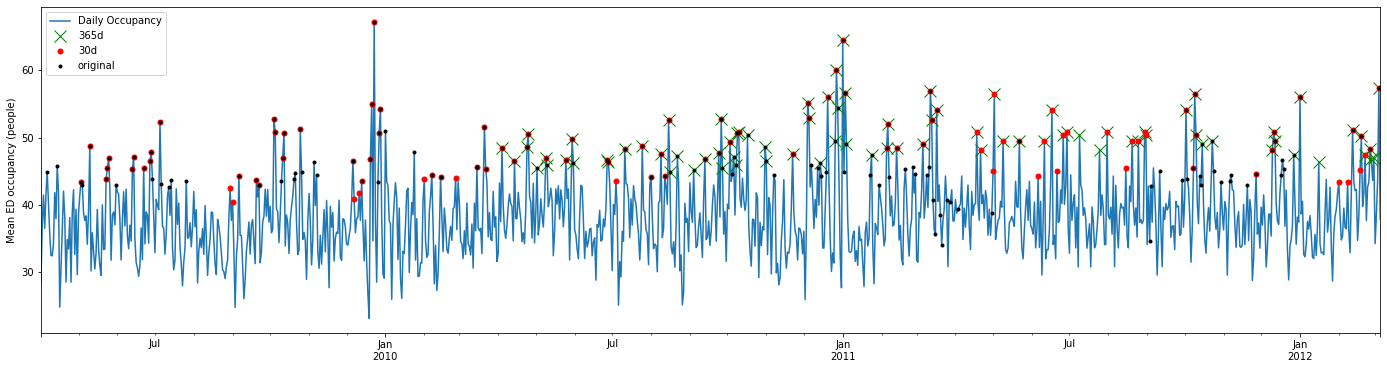

In [22]:
dff = df[-1200:]

target_col = 'occupancy'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))
dff[dff.class_RollingQuantile365d == 1][target_col].plot(ax=ax,style='xg',markersize=12)
dff[dff.class_RollingQuantile30d == 1][target_col].plot(ax=ax,style='.r',markersize=12)
dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')


ax.set_ylabel('Mean ED occupancy (people)')
ax.set_xlabel('')
ax.legend(['Daily Occupancy','365d','30d','original'],frameon=True,loc='upper left')

dff = df[-2400:-1200]

target_col = 'occupancy'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))
dff[dff.class_RollingQuantile365d == 1][target_col].plot(ax=ax,style='xg',markersize=12)
dff[dff.class_RollingQuantile30d == 1][target_col].plot(ax=ax,style='.r',markersize=12)
dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')


ax.set_ylabel('Mean ED occupancy (people)')
ax.set_xlabel('')
ax.legend(['Daily Occupancy','365d','30d','original'],frameon=True,loc='upper left')

dff = df[-3600:-2400]

target_col = 'occupancy'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))
dff[dff.class_RollingQuantile365d == 1][target_col].plot(ax=ax,style='xg',markersize=12)
dff[dff.class_RollingQuantile30d == 1][target_col].plot(ax=ax,style='.r',markersize=10)
dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')


ax.set_ylabel('Mean ED occupancy (people)')
ax.set_xlabel('')
ax.legend(['Daily Occupancy','365d','30d','original'],frameon=True,loc='upper left')

In [23]:
df_final = pd.DataFrame(df.occupancy)

In [24]:
df_final['flag_target'] = (df_final.occupancy > df_final.occupancy.rolling(360).quantile(0.9)).astype(int)

In [32]:
def get_class_imb(df,class_col = 'flag_target'):
    "Calc and print class imbalance."
    ones = df[class_col].sum()
    class_fraction = ones/len(df)
    print('{0:.2f}'.format(class_fraction))
    return

get_class_imb(df_final)

0.12


In [33]:
df_final.rename(columns={'occupancy':'EDMeanOcc'},inplace=True)

In [34]:
df_final = df_final.loc[pd.datetime(2011,9,1):]

In [35]:
df_final.head()

,EDMeanOcc,flag_target
dt_date,,
2011-09-01,34.125000,0
2011-09-02,42.791667,0
2011-09-03,34.708333,0
2011-09-04,42.791667,0
2011-09-05,37.416667,0


In [36]:
get_class_imb(df_final)

0.13


In [37]:
df_final.to_pickle('./../../data/interim/D3_dailyTS/EDdaily_occupancy_classRollQ90_clipped.pkl')

In [24]:
break

SyntaxError: 'break' outside loop (cell_name, line 4)

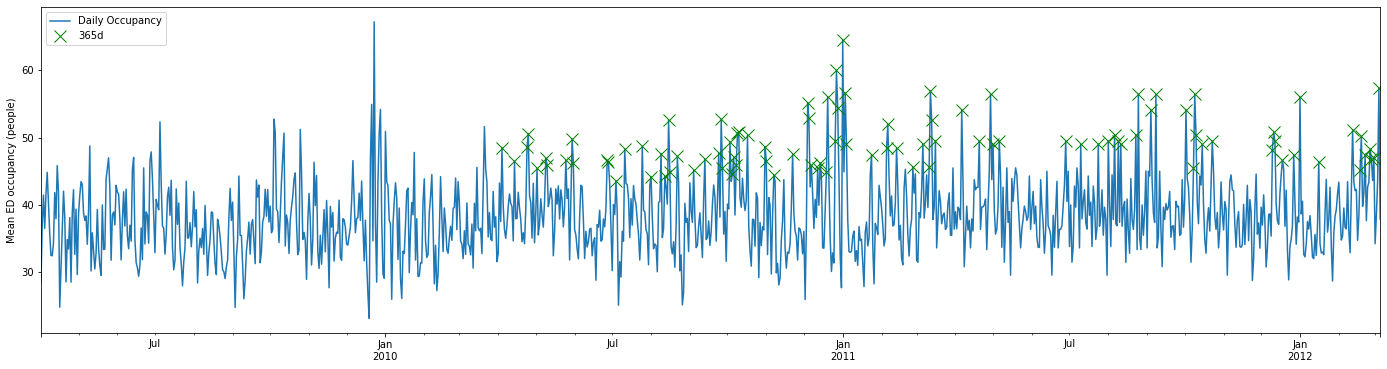

In [45]:
dff = df_final[-3600:-2400]

target_col = 'EDMeanOcc'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))
dff[dff.flag_target == 1][target_col].plot(ax=ax,style='xg',markersize=12)
# dff[dff.class_RollingQuantile30d == 1][target_col].plot(ax=ax,style='.r',markersize=10)
# dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')


ax.set_ylabel('Mean ED occupancy (people)')
ax.set_xlabel('')
ax.legend(['Daily Occupancy','365d','30d','original'],frameon=True,loc='upper left')

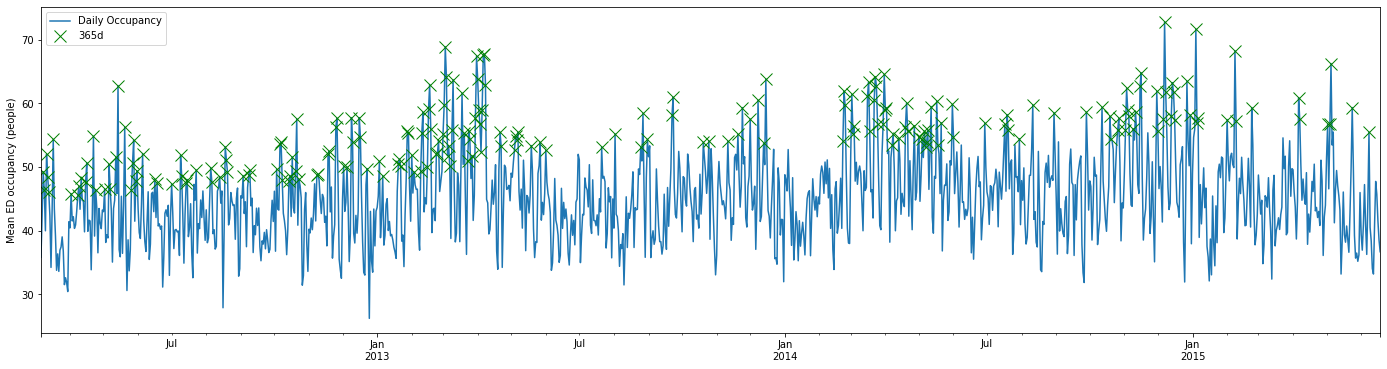

In [46]:
dff = df_final[-2400:-1200]

target_col = 'EDMeanOcc'
fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))
dff[dff.flag_target == 1][target_col].plot(ax=ax,style='xg',markersize=12)
# dff[dff.class_RollingQuantile30d == 1][target_col].plot(ax=ax,style='.r',markersize=10)
# dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')


ax.set_ylabel('Mean ED occupancy (people)')
ax.set_xlabel('')
ax.legend(['Daily Occupancy','365d','30d','original'],frameon=True,loc='upper left')

In [56]:
df_final

,EDMeanOcc,flag_target
dt_date,,
2009-04-01,28.458333,0
2009-04-02,36.875000,0
2009-04-03,41.458333,0
2009-04-04,36.541667,0
2009-04-05,41.625000,0
2009-04-06,44.833333,0
2009-04-07,40.333333,0
2009-04-08,35.750000,0
2009-04-09,32.500000,0


In [76]:
df_final['date'] = df_final.index
df_final['year'] = df_final.apply(lambda x : x.date.date().year, axis=1)

df_final.groupby('year').describe()['EDMeanOcc']#.plot()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2009,275.0,37.204697,5.786005,23.166667,33.166667,36.875000,40.500000,67.166667
2010,365.0,38.385845,5.737088,25.125000,34.541667,37.875000,41.875000,59.958333
2011,365.0,39.462329,5.600163,27.875000,35.958333,38.458333,42.625000,64.500000
2012,366.0,42.045423,5.926714,26.250000,37.916667,42.062500,45.833333,62.791667
2013,365.0,45.887900,6.884645,31.500000,40.791667,45.375000,50.041667,68.875000
2014,365.0,47.768037,6.973670,31.875000,42.958333,47.250000,52.000000,72.791667
2015,365.0,45.066438,6.882971,27.875000,39.958333,44.625000,49.458333,71.666667
2016,366.0,48.047359,7.582371,28.416667,42.750000,47.229167,53.031250,75.833333
2017,365.0,50.583219,7.378390,35.000000,44.750000,50.166667,55.375000,72.750000


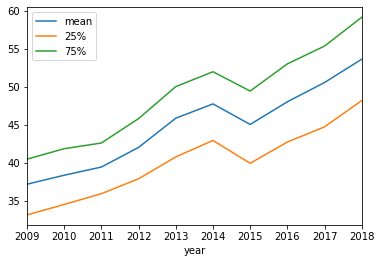

In [82]:
df_final.groupby('year').describe()['EDMeanOcc'][['mean','25%','75%']].plot()

In [74]:
df_final.groupby('year').count()['flag_target']

year
2009    275
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    273
Name: flag_target, dtype: int64

# Dev 

In [6]:
break

SyntaxError: 'break' outside loop (<ipython-input-6-6aaf1f276005>, line 1)

In [27]:
df['datetime'] = df.index

In [30]:
df = make_callender_columns(df,'datetime','dt')

----------------------------------------
Making callender columns from:  datetime


In [33]:
df = df.query('dt_year >= 2012')

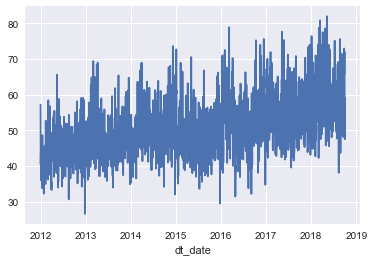

In [36]:
df.groupby(['dt_date']).mean()['EDocc'].plot()

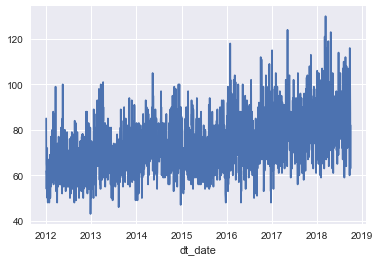

In [37]:
df.groupby(['dt_date']).max()['EDocc'].plot()

In [38]:
df.groupby(['dt_date']).mean()['EDocc'].describe()

count    2465.000000
mean       50.926640
std         8.143732
min        26.541667
25%        45.291667
50%        50.166667
75%        55.791667
max        82.000000
Name: EDocc, dtype: float64

In [39]:
df.groupby(['dt_date']).max()['EDocc'].describe()

count    2465.000000
mean       73.701014
std        11.719750
min        43.000000
25%        65.000000
50%        73.000000
75%        81.000000
max       130.000000
Name: EDocc, dtype: float64

In [48]:
occD = pd.DataFrame(df.groupby(['dt_date']).mean()['EDocc'])

In [49]:
occD.head()

,EDocc
dt_date,
2012-01-01,57.166667
2012-01-02,40.458333
2012-01-03,43.625000
2012-01-04,36.291667
2012-01-05,36.000000


In [50]:
occD['date'] = occD.index

In [51]:
occD.head(2)

,EDocc,date
dt_date,,
2012-01-01,57.166667,2012-01-01
2012-01-02,40.458333,2012-01-02


In [54]:
occD['date'] = pd.to_datetime(occD['date'])

occD = make_callender_columns(occD,'date','d')

In [56]:
occD.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend
dt_date,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0


In [78]:
year_describe = pd.DataFrame(occD.groupby(['d_year']).quantile(0.85)['EDocc']).rename(columns={'EDocc':'quantile'})
year_describe

,quantile
d_year,
2012,50.760417
2013,55.116667
2014,58.416667
2015,55.475000
2016,59.177083
2017,63.341667
2018,68.425000


In [79]:
occD_yearly = occD.merge(year_describe,left_on='d_year',right_index=True)
occD_yearly.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend,quantile
dt_date,,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1,50.760417
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0,50.760417
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0,50.760417
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0,50.760417
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0,50.760417


In [80]:
occD_yearly['flag'] = occD_yearly.apply(lambda x : x.EDocc > x['quantile'], axis=1).astype(int)

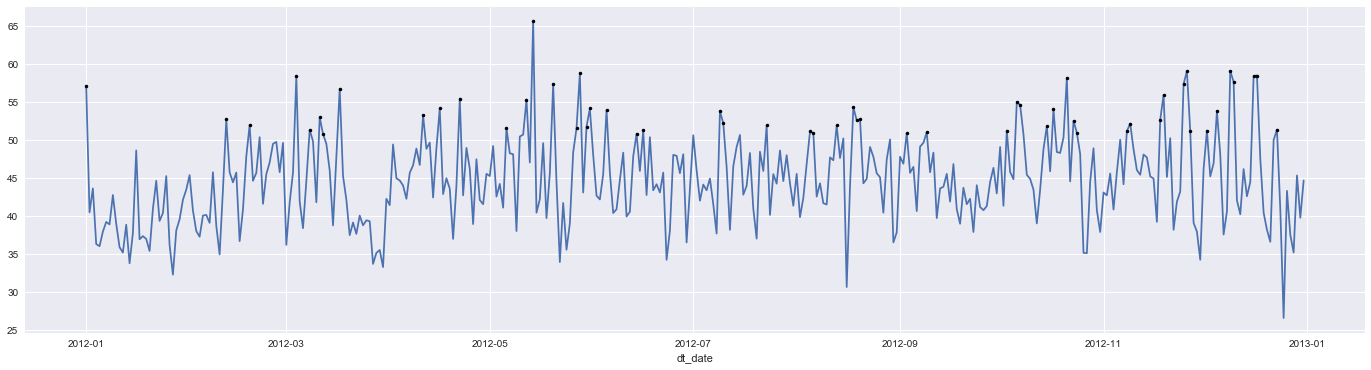

In [93]:
dff = occD_yearly.query('d_year == 2012')

target_col = 'EDocc'

fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))

dff[dff.flag == 1][target_col].plot(ax=ax,style='.k')